In [7]:
# import ROOT
import math
import uproot
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.patches as patches
from scipy.stats import norm

file = uproot.open("test-minimal-gamma-5Tz-20GeV-2000evts.root")

ntuple = file["tuple"]

# Access and analyze the data in each branch
event_ids = ntuple["eventID"]
num_hits = ntuple["numHits"]
hit_y = ntuple["HitY"]
hit_z = ntuple["HitZ"]
sig = ntuple["sig"]

ntuple.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eventID              | float                    | AsDtype('>f4')
numHits              | float                    | AsDtype('>f4')
HitY                 | float                    | AsDtype('>f4')
HitZ                 | float                    | AsDtype('>f4')
sig                  | float                    | AsDtype('>f4')


In [8]:
def get(df, event):
    return df[df["eventID"] == event].copy()

# convert ntuple to pandas df
df = ntuple.arrays(["eventID", "numHits", "HitY", "HitZ", "sig"], library="pd")

# extract true hits
true_hits = df[(df["HitY"] < 1000000) & (df["numHits"] > 0)].copy()
true_hits["y_index"] = true_hits["HitY"] % 10000
true_hits["layer"] = (true_hits["HitY"] - true_hits["y_index"]) / 10000
true_hits["z_index"] = true_hits["HitZ"] % 10000
true_hits["n_neighbors"] = (true_hits["HitZ"] - true_hits["z_index"]) / 10000
true_hits["energy"] = true_hits["sig"] % 10
true_hits["neighbor_energy"] = (true_hits["sig"] / 10).astype(int) / 10000.
true_hits = true_hits[["eventID", "numHits", "y_index", "z_index", "layer", "n_neighbors", "energy", "neighbor_energy"]]

# extract Outside Energy data
outside = df[(df["HitY"] >= 1000000)].copy()
outside["HitY"] = outside["HitY"] / 1000000
outside.rename(columns = {"HitY": "layer", "HitZ": "energy_full", "sig": "energy_below"}, inplace = True)

# extract MIPs data
mips = df[(df["numHits"] < 0)].copy()
mips = mips[mips["sig"]>=2]

mips["y_index"] = mips["HitY"] % 10000
mips["layer"] = (mips["HitY"] - mips["y_index"]) / 10000
mips.rename(columns = {"HitZ": "z_index"}, inplace = True)
mips = mips[["eventID", "numHits", "y_index", "z_index", "layer", "sig"]]
mips["KE"] = mips["sig"] % 1

In [9]:
true_hits

,eventID,numHits,y_index,z_index,layer,n_neighbors,energy,neighbor_energy
0,0.0,2425.0,999.0,199.0,0.0,1.0,0.002457,0.0024
1,0.0,2425.0,1000.0,200.0,0.0,1.0,0.002457,0.0024
2,0.0,2425.0,993.0,162.0,1.0,0.0,0.002234,0.0000
3,0.0,2425.0,999.0,199.0,1.0,1.0,0.002625,0.0090
4,0.0,2425.0,1000.0,200.0,1.0,1.0,0.009064,0.0026
...,...,...,...,...,...,...,...,...
7805188,1999.0,2670.0,1399.0,72.0,39.0,1.0,0.001099,0.0000
7805189,1999.0,2670.0,1400.0,72.0,39.0,1.0,0.004028,0.0010
7805190,1999.0,2670.0,1400.0,72.0,39.0,1.0,0.004028,0.0000
7805191,1999.0,2670.0,1708.0,395.0,39.0,0.0,0.002136,0.0000


In [17]:
def cluster(df):
    # given data of one event
    # Set clustering params
    adjacent_distance = euclidean_distances([[1, 1]], [[0, 0]])[0, 0]  # Calculate the diagonal Euclidean distance
    eps = adjacent_distance  # Set the eps parameter to the diagonal distance

    merged_data = pd.DataFrame()

    for layer in df["layer"].unique():
        layer_data = df[df["layer"] == layer].copy()
        dbscan = DBSCAN(eps=eps, min_samples=1)
        dbscan.fit(layer_data[['z_index', 'y_index']])
        labels = dbscan.labels_
        layer_data["cluster"] = labels + layer * 10000
        merged_data = pd.concat([merged_data, layer_data])

    return merged_data

import pandas as pd
import numpy as np

import pandas as pd

def merge_data(df1, df2):
    columns = ['eventID', 'layer', 'z_index', 'y_index']
    
    # Preparing df1: dropping unwanted columns
    df1 = df1.drop(columns=["n_neighbors", "neighbor_energy"])
    
    # Preparing df2: filtering, dropping columns, and adding new column
    df2 = df2[df2["sig"] >= 2]
    df2 = df2.drop(columns=["numHits", "KE", "sig"])
    df2["num_mips"] = 1
    
    # Merge using left join to keep all of true_hits and only matching mips rows
    merged_df = pd.merge(df1, df2, on=columns, how='left', suffixes=('', '_mips'))

    # Group by the columns (except 'energy') and aggregate 
    # Get min and max values for the 'energy' column
    aggregated_df = (merged_df.groupby(columns + ['numHits'])
                     .agg({'energy': 'mean', 'num_mips': 'sum'})
                     .reset_index())
    
    return aggregated_df

In [19]:
# columns: cluster_size (num_hits), min_y, min_z, max_y, max_z, layer, event number
# target: num_mips

def produce_cluster_frame(data, event):
    frame = []
    
    for i in data["cluster"].unique():
        # extract data
        ith_cluster = data.query(f"cluster == {i}")
        y_coords = ith_cluster['y_index'].tolist()
        z_coords = ith_cluster['z_index'].tolist()
        num_mips = ith_cluster["num_mips"].sum()
        energy = ith_cluster["energy"].sum()
        
        # set params
        
        cluster_size = len(y_coords)
        min_y = min(y_coords)
        max_y = max(y_coords)
        min_z = min(z_coords)
        max_z = max(z_coords)
        layer = int(i/10000)
        
        frame.append({"cluster_size": cluster_size,
                      "num_mips":num_mips,
                      "min_y":min_y, 
                      "min_z":min_z, 
                      "max_y":max_y, 
                      "max_z":max_z, 
                      "layer":layer, 
                      "energy": energy,
                      "eventID":event})

    return frame

In [21]:
merge_data(get(true_hits,1),get(mips,1))

,eventID,layer,z_index,y_index,numHits,energy,num_mips
0,1.0,0.0,198.0,967.0,2406.0,0.003487,1.0
1,1.0,0.0,199.0,998.0,2406.0,0.002289,1.0
2,1.0,0.0,199.0,999.0,2406.0,0.003723,1.0
3,1.0,0.0,200.0,1000.0,2406.0,0.005249,1.0
4,1.0,1.0,186.0,1025.0,2406.0,0.032383,0.0
...,...,...,...,...,...,...,...
2301,1.0,33.0,179.0,1420.0,2406.0,0.005188,2.0
2302,1.0,33.0,181.0,1339.0,2406.0,0.007629,0.0
2303,1.0,35.0,111.0,1689.0,2406.0,0.001892,0.0
2304,1.0,35.0,111.0,1690.0,2406.0,0.005005,0.0


In [22]:
cluster_data = cluster(merge_data(get(true_hits,1),get(mips,1)))
data = produce_cluster_frame(cluster_data, 1)
data = pd.DataFrame(data)
data

,cluster_size,num_mips,min_y,min_z,max_y,max_z,layer,energy,eventID
0,1,1.0,967.0,198.0,967.0,198.0,0,0.003487,1
1,2,2.0,998.0,199.0,999.0,199.0,0,0.006012,1
2,1,1.0,1000.0,200.0,1000.0,200.0,0,0.005249,1
3,1,0.0,1025.0,186.0,1025.0,186.0,1,0.032383,1
4,2,0.0,1013.0,188.0,1013.0,189.0,1,0.009880,1
...,...,...,...,...,...,...,...,...,...
1704,1,0.0,1051.0,299.0,1051.0,299.0,29,0.013184,1
1705,1,2.0,1420.0,179.0,1420.0,179.0,33,0.005188,1
1706,1,0.0,1339.0,181.0,1339.0,181.0,33,0.007629,1
1707,2,0.0,1689.0,111.0,1690.0,111.0,35,0.006897,1


In [23]:
for i in range(10):
    data = []
    for event in range(i*200,200+i*200):
        if event %10 == 0:
            print("Progress: ", event)
        cluster_data = cluster(merge_data(get(true_hits,event),get(mips,event)))
        data += produce_cluster_frame(cluster_data, event)

    data = pd.DataFrame(data)
    data.to_csv("data"+str(event)+"_correct", index="false")
    print("Generated csv file: ", "data"+str(event))

Progress:  0
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
Progress:  110
Progress:  120
Progress:  130
Progress:  140
Progress:  150
Progress:  160
Progress:  170
Progress:  180
Progress:  190
Generated csv file:  data199
Progress:  200
Progress:  210
Progress:  220
Progress:  230
Progress:  240
Progress:  250
Progress:  260
Progress:  270
Progress:  280
Progress:  290
Progress:  300
Progress:  310
Progress:  320
Progress:  330
Progress:  340
Progress:  350
Progress:  360
Progress:  370
Progress:  380
Progress:  390
Generated csv file:  data399
Progress:  400
Progress:  410
Progress:  420
Progress:  430
Progress:  440
Progress:  450
Progress:  460
Progress:  470
Progress:  480
Progress:  490
Progress:  500
Progress:  510
Progress:  520
Progress:  530
Progress:  540
Progress:  550
Progress:  560
Progress:  570
Progress:  580
Progress:  590
Generated csv file:  data599
Progress:  600
Progress:

In [70]:
data

,cluster_size,num_mips,min_y,min_z,max_y,max_z,layer,eventID
0,1,1,999.0,199.0,999.0,199.0,0,0
1,1,1,1000.0,200.0,1000.0,200.0,0,0
2,1,1,993.0,162.0,993.0,162.0,1,0
3,1,1,999.0,199.0,999.0,199.0,1,0
4,1,1,1000.0,200.0,1000.0,200.0,1,0
...,...,...,...,...,...,...,...,...
3308584,1,0,1508.0,292.0,1508.0,292.0,37,1999
3308585,1,1,987.0,242.0,987.0,242.0,39,1999
3308586,1,1,1345.0,67.0,1345.0,67.0,39,1999
3308587,2,0,1399.0,72.0,1400.0,72.0,39,1999


In [66]:
data = []
for i in range(10):
    event = (i+1)*200-1
    data.append(pd.read_csv('data'+str(event), index_col=0))

data = pd.concat(data, ignore_index=True)
grouped_data = data.groupby('eventID')['num_mips'].sum().reset_index()
grouped_data

,eventID,num_mips
0,0,1204
1,1,1200
2,2,1146
3,3,1102
4,4,1140
...,...,...
1995,1995,1179
1996,1996,1083
1997,1997,1247
1998,1998,1190


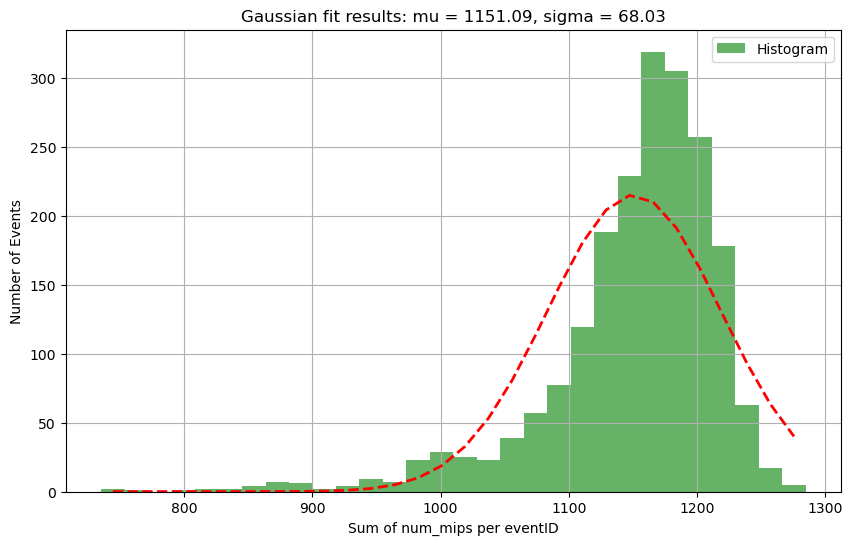

In [71]:
# Plotting histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(grouped_data['num_mips'], bins=30, density=False, alpha=0.6, color='g', label='Histogram')

# Fitting the Gaussian to the bins of the histogram
bin_centers = 0.5*(bins[:-1] + bins[1:])
(mu, sigma) = norm.fit(grouped_data['num_mips'])

# Adding the Gaussian fit line - we'll scale it to the histogram
y = norm.pdf(bin_centers, mu, sigma)
y = y * (bins[1] - bins[0]) * len(grouped_data['num_mips'])
l = plt.plot(bin_centers, y, 'r--', linewidth=2)

plt.title(f'Gaussian fit results: mu = {mu:.2f}, sigma = {sigma:.2f}')
plt.xlabel('Sum of num_mips per eventID')
plt.ylabel('Number of Events')
plt.legend()

plt.grid(True)
plt.show()


In [72]:
mips

,eventID,numHits,y_index,z_index,layer,sig,KE
2455,0.0,-1408.0,1000.0,200.0,0.0,2.500000,0.500000
2456,0.0,-1408.0,1000.0,200.0,1.0,2.500000,0.500000
2457,0.0,-1408.0,1001.0,200.0,2.0,2.500000,0.500000
2458,0.0,-1408.0,1004.0,199.0,3.0,2.500000,0.500000
2459,0.0,-1408.0,1007.0,199.0,4.0,2.392254,0.392254
...,...,...,...,...,...,...,...
7806610,1999.0,-1392.0,1015.0,195.0,5.0,2.012881,0.012881
7806611,1999.0,-1392.0,1009.0,200.0,5.0,2.002604,0.002604
7806612,1999.0,-1392.0,669.0,318.0,7.0,2.002569,0.002569
7806613,1999.0,-1392.0,1108.0,160.0,5.0,2.002722,0.002722


In [73]:
true_hits

,eventID,numHits,y_index,z_index,layer,n_neighbors,energy,neighbor_energy
0,0.0,2425.0,999.0,199.0,0.0,1.0,0.002457,0.0024
1,0.0,2425.0,1000.0,200.0,0.0,1.0,0.002457,0.0024
2,0.0,2425.0,993.0,162.0,1.0,0.0,0.002234,0.0000
3,0.0,2425.0,999.0,199.0,1.0,1.0,0.002625,0.0090
4,0.0,2425.0,1000.0,200.0,1.0,1.0,0.009064,0.0026
...,...,...,...,...,...,...,...,...
7805188,1999.0,2670.0,1399.0,72.0,39.0,1.0,0.001099,0.0000
7805189,1999.0,2670.0,1400.0,72.0,39.0,1.0,0.004028,0.0010
7805190,1999.0,2670.0,1400.0,72.0,39.0,1.0,0.004028,0.0000
7805191,1999.0,2670.0,1708.0,395.0,39.0,0.0,0.002136,0.0000


In [ ]:
# Performing the left anti-join
merged = mips.merge(true_hits[['y_index', 'z_index']], on=['y_index', 'z_index'], how='left', indicator=True)
mips_without_true_hits = mips[merged['_merge'] == 'left_only']

In [79]:
def filter_mips(mips_group, true_hits_group):
    mips_group = mips_group.reset_index(drop=True)
    true_hits_group = true_hits_group.reset_index(drop=True)
    merged = mips_group.merge(true_hits_group[['y_index', 'z_index']], on=['y_index', 'z_index'], how='left', indicator=True)
    return mips_group[merged['_merge'] == 'left_only']

mips_groups = mips.groupby('eventID')
true_hits_groups = true_hits.groupby('eventID')

# Use a set for faster membership checking
mips_eventIDs = set(true_hits['eventID'].unique())

result_list = [filter_mips(mips_groups.get_group(event_id), true_hits_groups.get_group(event_id))
               for event_id in mips_eventIDs]

mips_without_true_hits = pd.concat(result_list).reset_index(drop=True)


/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mips_group[merged['_merge'] == 'left_only']
/var/folders/s2/qsqcpmd946xc2096q_lq7_hw0000gn/T/ipykernel_77844/3936712088.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index

In [80]:
mips_without_true_hits

,eventID,numHits,y_index,z_index,layer,sig,KE
0,0.0,-1408.0,1128.0,201.0,14.0,2.004574,0.004574
1,0.0,-1408.0,903.0,217.0,16.0,2.004141,0.004141
2,0.0,-1408.0,852.0,203.0,17.0,2.009293,0.009293
3,0.0,-1408.0,932.0,203.0,17.0,2.006397,0.006397
4,0.0,-1408.0,1390.0,129.0,19.0,2.006863,0.006863
...,...,...,...,...,...,...,...
173786,1999.0,-1392.0,1175.0,220.0,15.0,2.002663,0.002663
173787,1999.0,-1392.0,991.0,198.0,4.0,2.009150,0.009150
173788,1999.0,-1392.0,977.0,257.0,7.0,2.004576,0.004576
173789,1999.0,-1392.0,974.0,266.0,6.0,2.001328,0.001328


In [89]:
sum_numHits = mips_without_true_hits.groupby('eventID')['numHits'].count().reset_index()

sum_numHits.numHits = sum_numHits.numHits
sum_numHits

,eventID,numHits
0,0.0,89
1,1.0,80
2,2.0,64
3,3.0,73
4,4.0,59
...,...,...
1995,1995.0,87
1996,1996.0,113
1997,1997.0,62
1998,1998.0,51


In [90]:
sum_numHits.to_csv("missing mips")